In [1]:
import warnings
import os
import json  # If loading presaved indexes using freeze_model
import shap
import time

import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedKFold, LeaveOneOut, GridSearchCV
from sklearn import neighbors, metrics
from dotenv import load_dotenv

from models.linear_regressions import Linear_reg
from scripts.model_actions import freeze_model

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100


warnings.filterwarnings("ignore")

shap.initjs()


# <u>Tentative de modélisation et prédiction de la variable : Intensité d'utilisation énergétique par mètre carré</u>

## <u>1 : Modélisations en prenant en compte la note Energy Star (E*)</u>
### <u>1.1 : Régressions linéaires</u>
### <u>1.2 : Potentielle méthode non linéaire : Régression KNN</u>

## <u>2 : Étude de l'importance de la note Energy Star</u>
### <u>2.1 : Modélisation sans utiliser de variables E* (E* Score ou E* certified)</u>
### <u>2.2 : Utilisation de la certification plutôt que le score</u>

<hr>

<b><u>Important :</u></b>

_note : La modélisation prend en compte la variable "electricity", celle ci représentant la majorité de la consommation énergétique, on peut considérer qu'il y ait une fuite de données. Néanmoins, la facilité d'obtention des relevés de consommation électrique des bâtiments (i.e. requête a la compagnie électrique) justifie, à mon sens, son utilisation dans la modélisation. Si néanmoins cette variable est considérée comme trop informative, il est possible de l'enlever du modèle en utilisant la méthode d'instance `regression.drop_col(["scaled_Electricity(kWh)"])`._

<hr>

## <u>1 : Modelisations prenant en compte toutes les variables retenues lors de l'étude</u>
### <u>1.1 : Regressions lineaires</u>

#### 1.1.a : Cross validation = Leave One Out
- On utilise dans un premier temps toutes les variables retenues lors de l'analyse exploratoire (breakpoint = export 1)
- Un split satisfaisant a deja été trouvé et fixé, ces données viendront sur-ecrire le split proposé par le modele
- On effectue 4 regressions (OLS, Ridge, Lasso et Elastic Net) avec les parametres par defaut de la classe pour la validation croisee : Leave One Out

In [2]:
general_file = "./data/seattle_std_scaled.csv"  # Used as backup


In [3]:
df_eui = pd.read_csv(general_file)
df_eui.set_index("OSEBuildingID", inplace=True)


In [4]:
## Opening split

with open("./data/split_eui.json") as json_file:
    splits = json.load(json_file)


In [5]:
ids_train = splits["train"]
ids_test = splits["test"]


In [6]:
df_eui.head()


,scaled_Electricity(kWh),scaled_GHGEmissionsIntensity(kgCO2e/ft2),scaled_PropertyArea(SquareMetre)Total,scaled_SourceEUI(kWh/m2),scaled_NaturalGas(kWh),BuildingAge,NumberofBuildings,NumberofFloors,ENERGYSTARScore,Building_proportion,...,ohe_Nbhood_DOWNTOWN,ohe_Nbhood_EAST,ohe_Nbhood_GREATER DUWAMISH,ohe_Nbhood_LAKE UNION,ohe_Nbhood_MAGNOLIA / QUEEN ANNE,ohe_Nbhood_NORTH,ohe_Nbhood_NORTHEAST,ohe_Nbhood_NORTHWEST,ohe_Nbhood_SOUTHEAST,ohe_Nbhood_SOUTHWEST
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
1,0.963847,1.770173,0.389139,1.012887,0.500705,95.0,1,12,60.0,1.000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.615322,1.799564,0.659821,0.913481,4.178122,26.0,1,11,61.0,0.855,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.380423,3.572830,-0.095878,1.536320,1.009034,96.0,1,10,56.0,1.000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.401384,1.074583,0.292078,0.455283,2.089235,96.0,1,11,27.0,1.000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-0.326328,3.945117,-0.029889,0.564008,2.706276,94.0,1,9,48.0,1.000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_eui.columns


Index(['scaled_Electricity(kWh)', 'scaled_GHGEmissionsIntensity(kgCO2e/ft2)',
       'scaled_PropertyArea(SquareMetre)Total', 'scaled_SourceEUI(kWh/m2)',
       'scaled_NaturalGas(kWh)', 'BuildingAge', 'NumberofBuildings',
       'NumberofFloors', 'ENERGYSTARScore', 'Building_proportion',
       'Parking_proportion', 'EnergyStarCert', 'target_SourceEUI(kWh/m2)',
       'target_GHGEmissionsIntensity(kgCO2e/ft2)', 'ohe_Ptype_Hospital',
       'ohe_Ptype_Hotel', 'ohe_Ptype_K-12 School', 'ohe_Ptype_Large Office',
       'ohe_Ptype_Mixed Use Property', 'ohe_Ptype_Office', 'ohe_Ptype_Other',
       'ohe_Ptype_Refrigerated Warehouse', 'ohe_Ptype_Residence Hall',
       'ohe_Ptype_Small & Medium medical facility',
       'ohe_Ptype_Small & Mid-Sized Office',
       'ohe_Ptype_Supermarket & Grocery store', 'ohe_Ptype_Warehouse',
       'ohe_Ptype_Worship Facility', 'ohe_Nbhood_BALLARD',
       'ohe_Nbhood_CENTRAL', 'ohe_Nbhood_DELRIDGE', 'ohe_Nbhood_DOWNTOWN',
       'ohe_Nbhood_EAST', 'ohe_Nbh

In [8]:
# Target : target_SourceEUI(kWh/m2) :

droplist = [
    "target_GHGEmissionsIntensity(kgCO2e/ft2)",  # Scaled target
    "scaled_SourceEUI(kWh/m2)",  # not to scale
    ]

df_model = df_eui.drop(columns=droplist)


In [9]:
eui_target = "target_SourceEUI(kWh/m2)"
eui_regression = Linear_reg(dataframe=df_model, target=eui_target)


In [10]:
# Forcing split : 

df_train_override = df_model[df_model.index.isin(ids_train)]
df_test_override = df_model[df_model.index.isin(ids_test)]


In [11]:
eui_regression.force_split(
    df_test_ovr=df_test_override,
    df_train_ovr=df_train_override
)


In [12]:
# Dropping the Cert (redundant)

eui_regression.drop_col(["EnergyStarCert"])


#### Exécution : 
Paramètres proposés :
- Ridge = 0.1, 30, step 0.04
- Elastic Net = Alpha = Alpha_ridge = 0.1, 30, step 0.04, default L1 ratio
- Lasso Alpha = 0.01, 10, 0.02

In [13]:
alphas_ridge = np.arange(0.1, 30, 0.04)
alphas_elnet = np.arange(0.1, 30, 0.04)
alphas_lasso = np.arange(0.01, 6, 0.01)

eui_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
)


In [14]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.1
Time used during fit = 7.176638250006363
Time used during predict = 7.062498480081558e-05


Ridge: 

Ridge best Alpha : 0.7400000000000001
Time used during fit = 0.09089812508318573
Time used during predict = 6.029102951288223e-05


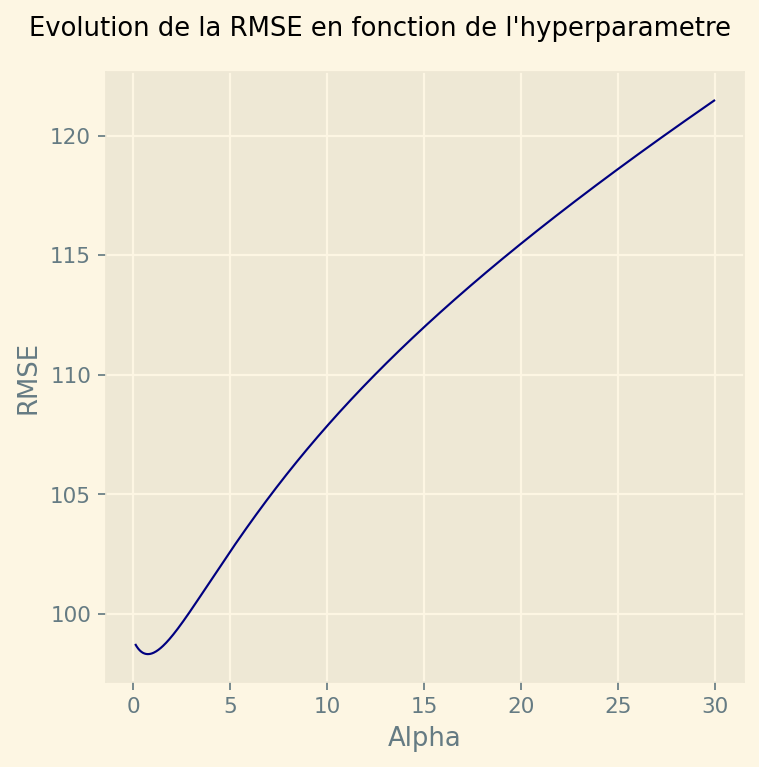

In [15]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")

eui_regression.ridge_plot()


LASSO: 

LASSO best Alpha : 0.5700000000000001
Time used during fit = 0.37162037496455014
Time used during predict = 9.737501386553049e-05


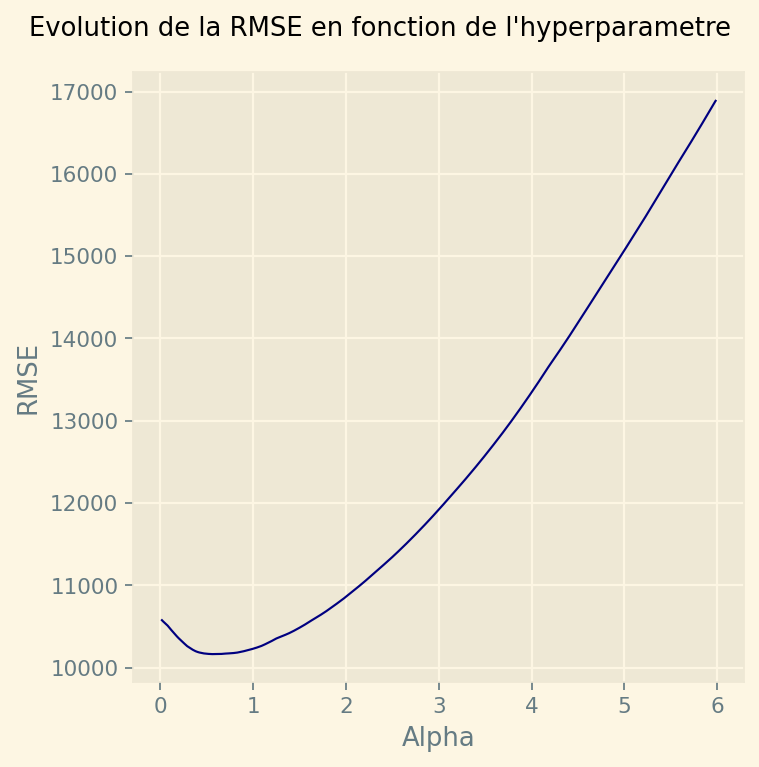

In [16]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")

eui_regression.lasso_plot()


In [17]:
metrics_l1out_estar = eui_regression.format_all_metrics()

metrics_l1out_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,103.091671,0.738351,98.326356,0.806016,100.813213,0.801729,211.88732,0.792946
Test,100.755938,0.750068,102.720646,0.740226,100.005053,0.75378,108.686858,0.709173
Test/Train,0.977,1.016,1.045,0.918,0.992,0.94,0.513,0.894


##### <u>Observations : 1.1.a :</u>
- Les modèles sont tous globalement performants.
- Le modèle Ridge semble être le plus performant sur les données d'entraînement avec une baisse du score R2 entre l'exécution sur les données d'entraînement et sur les données de test.
- OLS est très stable, on remarque des scores plus faibles que les autres régressions mais le modèle est le seul à excéder les performances attendues lors du passage au test (R2 plus haut, RMSE plus faible)
- Le modèle LASSO offre les meilleures performances sur les données de test : même si la régression Ridge est plus efficace sur le jeu d'entraînement, LASSO s'applique mieux aux données de test (meilleur score R2 et RMSE que Ridge dans le cas du test).
- ElasticNet semble être le moins bon des modèles avec une RMSE de +|- 149 kWh/m2 sur le jeu de test

<hr>


In [18]:
# Saving the Lasso_cv for future comparison :

lasso_cv_l1out_estar = eui_regression.lasso_cv



#### 1.1.b : Cross validation = RepeatedKfold (10 folds aléatoires, 3 répétitions)

- On utilise exactement les mêmes paramètres que lors de la validation croisée utilisant Leave One Out
- On effectue 4 régressions (OLS, Ridge, Lasso et Elastic Net) mise à jour des paramètres par défaut de la classe pour la validation croisée : RepeatedKfold(30 fois : 10 splits, 3 exécutions).
- Kfolds étant souvent beaucoup plus lourd à exécuter que Leave One Out, on attend de meilleurs scores mais des temps de traitement plus élevés

In [19]:
## Changing CV to RepeatedKfold :
k_folds = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

eui_regression.common_parameters["cv"] = k_folds


In [20]:
# Same split, same parameters, except cv = kfolds :

eui_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
)


In [21]:
metrics_kfold_estar = eui_regression.format_all_metrics()


In [22]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.1
Time used during fit = 42.67186883406248
Time used during predict = 0.0004148749867454171


In [23]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")


Ridge: 

Ridge best Alpha : 0.66
Time used during fit = 18.332412209012546
Time used during predict = 0.003450209042057395


In [24]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")


LASSO: 

LASSO best Alpha : 0.54
Time used during fit = 2.469985708943568
Time used during predict = 0.00013516598846763372


In [25]:
print("# Metriques des regressions utilisant Kfold #")
metrics_kfold_estar


# Metriques des regressions utilisant Kfold #


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,99.464371,0.755986,0.871025,0.806401,98.094811,0.802168,218.234635,0.792946
Test,100.755938,0.750068,102.466601,0.741509,100.008468,0.753763,108.686858,0.709173
Test/Train,1.013,0.992,117.639,0.92,1.02,0.94,0.498,0.894


In [26]:
print("# Metriques des regressions utilisant Leave One Out #")
metrics_l1out_estar


# Metriques des regressions utilisant Leave One Out #


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,103.091671,0.738351,98.326356,0.806016,100.813213,0.801729,211.88732,0.792946
Test,100.755938,0.750068,102.720646,0.740226,100.005053,0.75378,108.686858,0.709173
Test/Train,0.977,1.016,1.045,0.918,0.992,0.94,0.513,0.894


##### Observations 1.1.b et comparaisons avec 1.1.a :

- Le temps d'exécution est largement supérieur, ce qui était attendu
- La régression Ridge semble profiter de validation croisée par KFolds. Les performances sur le jeu d'entraînement révèlent un overfitting (0.87 kWh/m2 de RMSE), mais il rentre dans les valeurs attendues (autour de 102kWh de RMSE) lors de son exécution sur les données de test
- La régression utilisant LASSO ne semble pas profiter significativement de la validation croisée par KFolds, mais les résultats obtenus restent bons.
<br> 
<hr>
<br>
<u><b>Choix de LASSO entraîné avec LeaveOneOut pour analyse de l'importance du score Energy Star :</b> <br></u>

- Elastic Net n'offre pas de gain significatif pour son temps d'entraînement largement supérieur
- On analyse LASSO L1Out plus en détails et c'est la régression principale qu'on utilisera pour comparer l'étape 1 à l'étape 2.

### <u>1.2 : Potentielle méthode non linéaire : Régression KNN</u>

Ici encore, le problème semble solvable en utilisant des méthodes linéaires. Il est possible néanmoins d'appliquer, comme dans le cas de la modélisation sur les GàES, une régression par KNN pour vérifier que d'autres méthodes ne sont pas plus performantes.

In [27]:
X_train, X_test = eui_regression.X_train, eui_regression.X_test
y_train, y_test = eui_regression.y_train, eui_regression.y_test

neighbors_candidates = [5, 7, 9, 11, 13, 15, 17, 19]

knnr = neighbors.KNeighborsRegressor()

# Grid search

l1out = LeaveOneOut()

param_grid_knnr = {'n_neighbors':neighbors_candidates}

score = "neg_mean_squared_error"

# KNN regressors Setup

knn_reg_l1o = GridSearchCV(
    estimator=knnr,
    param_grid=param_grid_knnr,
    cv=l1out,
    scoring=score
)

knn_reg_rkf = GridSearchCV(
    estimator=knnr,
    param_grid=param_grid_knnr,
    cv=k_folds,
    scoring=score
)


In [28]:
knnr_l1o_fit_ts = time.perf_counter()

knn_reg_l1o.fit(
    X=X_train,
    y=y_train
)

knnr_l1o_fit_tf = time.perf_counter()

time_to_fit_knn_l1out = knnr_l1o_fit_tf - knnr_l1o_fit_ts

rmse_knnr_l1o = np.sqrt(abs(knn_reg_l1o.best_score_))
y_pred_train_l1o = knn_reg_l1o.predict(X_train)
r2_knnr_l1o = metrics.r2_score(y_true=eui_regression.y_train, y_pred=y_pred_train_l1o)


In [29]:
print(f"RMSE Regression KNN, Cross Val : Leave one out = {rmse_knnr_l1o}")
print(f"Score R2 Regression KNN, Cross Val : Leave one out = {r2_knnr_l1o}")
print(f"Temps fit : {time_to_fit_knn_l1out}")
print(f"Meilleur hyperparametre : {knn_reg_l1o.best_params_}")


RMSE Regression KNN, Cross Val : Leave one out = 175.54441493262067
Score R2 Regression KNN, Cross Val : Leave one out = 0.3832699079371096
Temps fit : 4.132689125020988
Meilleur hyperparametre : {'n_neighbors': 11}


In [30]:
knnr_rkf_fit_ts = time.perf_counter()

knn_reg_rkf.fit(
    X=X_train,
    y=y_train
)

knnr_rkf_fit_tf = time.perf_counter()

time_to_fit_knn_rkf = knnr_rkf_fit_tf - knnr_rkf_fit_ts

rmse_knnr_rkf = np.sqrt(abs(knn_reg_rkf.best_score_))
y_pred_train_rkf = knn_reg_rkf.predict(X_train)
r2_knnr_rkf = metrics.r2_score(y_true=eui_regression.y_train, y_pred=y_pred_train_l1o)


In [31]:
print(f"RMSE Regression KNN, Cross Val : Repeated KFolds = {rmse_knnr_rkf}")
print(f"Score R2 Regression KNN, Cross Val : Repeated KFolds = {r2_knnr_rkf}")
print(f"Temps fit : {time_to_fit_knn_rkf}")
print(f"Meilleur hyperparametre : {knn_reg_rkf.best_params_}")


RMSE Regression KNN, Cross Val : Repeated KFolds = 177.5771590856325
Score R2 Regression KNN, Cross Val : Repeated KFolds = 0.3832699079371096
Temps fit : 0.46353358402848244
Meilleur hyperparametre : {'n_neighbors': 13}


#### Observations sur KNN :
- Comme dans le cas des GàES, une méthode de régression utilisant KNN n'est pas souhaitable. Le score R2 du modèle s'effondre et l'erreur augmente grandement.
- Les modèles de régression linéaires semblent, dans ce cas et dans le cadre des modèles essayés, suffisamment précis et pertinents.
- Il n'est pas impossible qu'une autre méthode de régression non linéaire soit plus performante (Random Forest Regressor par exemple), mais le modèle Ridge validé par Repeated Kfolds se montre suffisamment satisfaisant pour justifier la non implémentation d'un méthode beaucoup plus lourde.

## <u>2 : Etude de l'importance de la note Energy Star</u>


### <u>2.1 : Utilisation de SHAP</u> pour déterminer l'importance des différentes variables sur la régression retenue lors de l'étape précédente :

- On identifiera quels sont les principales features qui entrent en compte lors de la modélisation
- On pourra voir si la variable Energy Star Score figure parmi les plus importantes features

In [32]:
target_and_cert = [eui_target, "EnergyStarCert"]

X_all = eui_regression.df_origin.drop(columns=target_and_cert).to_numpy()
X100 = shap.utils.sample(X_all, 100) # 100 instances for use as the background distribution

features = eui_regression.df_origin.drop(columns=target_and_cert).columns

explainer = shap.LinearExplainer(lasso_cv_l1out_estar, X100, feature_names=features)
shap_values = explainer(X_all)


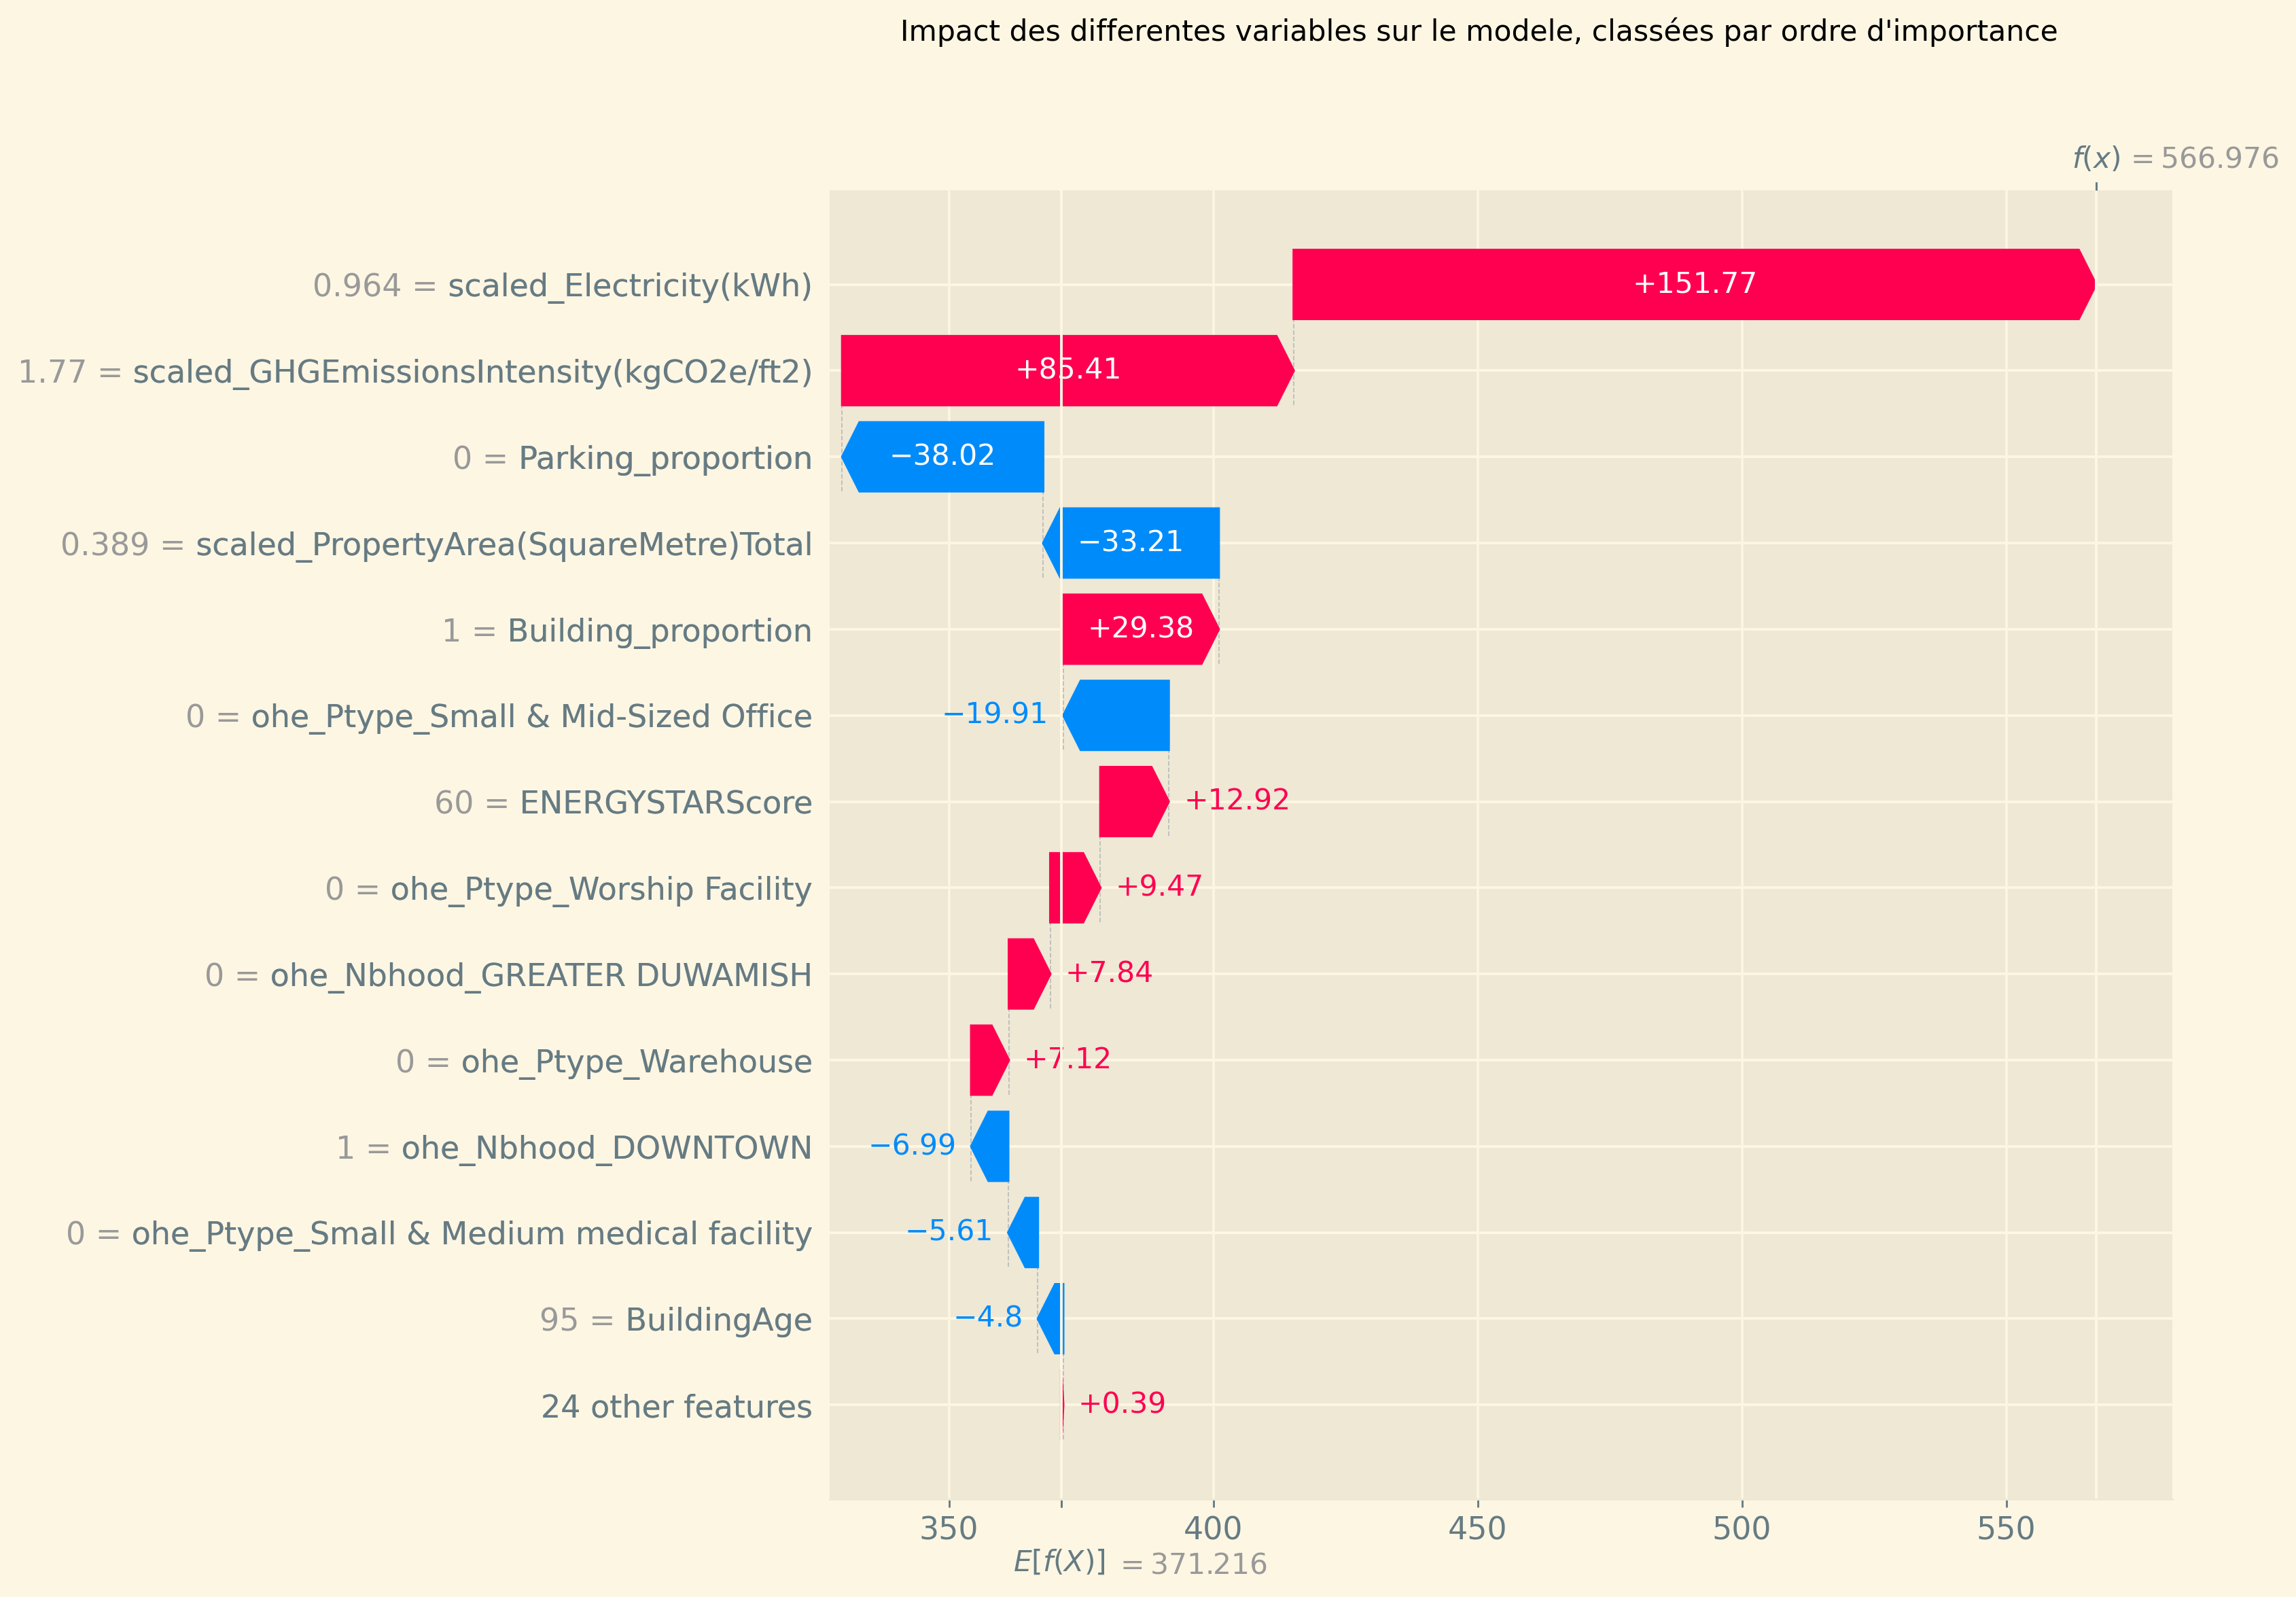

In [33]:
sample_ind = 18
my_waterfall = shap.plots.waterfall(shap_values[0], max_display=14, show=False)
my_waterfall.figure.set_size_inches(10, 10)
my_waterfall.figure.set_dpi(pc_dpi)

my_waterfall.suptitle("Impact des differentes variables sur le modele, classées par ordre d'importance")

plt.show()


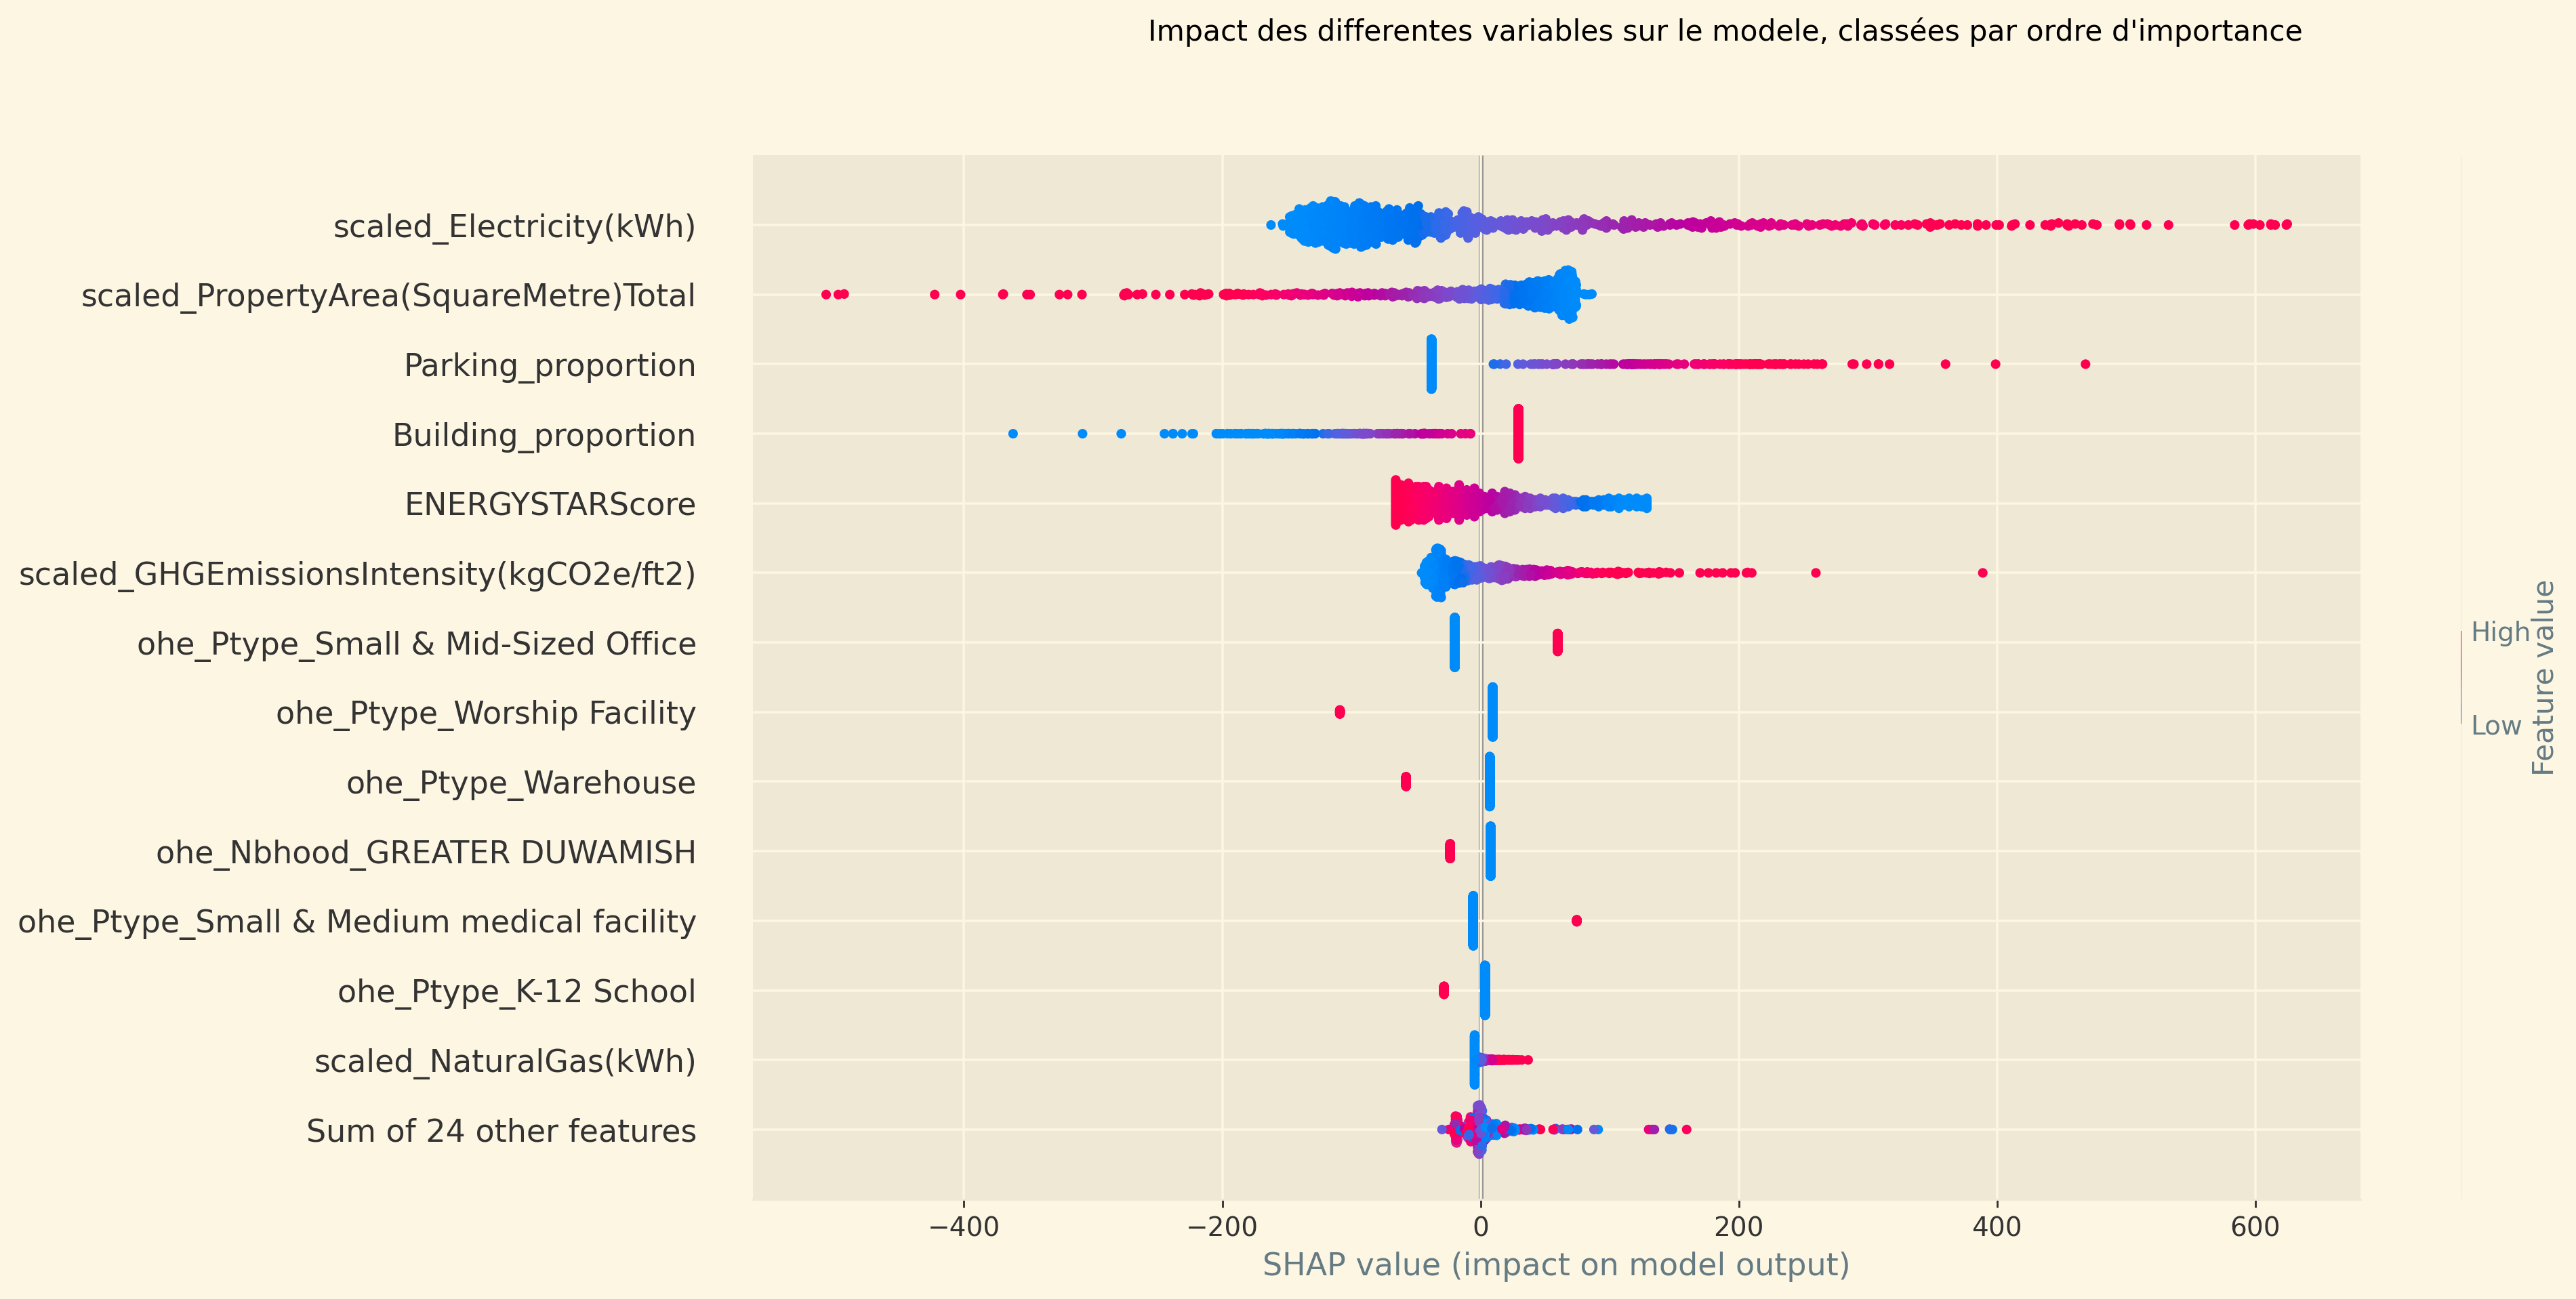

In [34]:
summary = shap.plots.beeswarm(shap_values, max_display=14, show=False)

summary.figure.set_size_inches(15, 8)
summary.figure.set_dpi(pc_dpi)

summary.suptitle("Impact des differentes variables sur le modele, classées par ordre d'importance")

plt.show()


#### Observations 2.1 : 

- Energy Star Score semble être une valeur très importante au modèle : le plot summary (n.2) montre que plus sa valeur est basse, plus l'intensité d'utilisation énergétique augmente. Des valeurs hautes du score ("bons" scores) sont corrélés avec une valeur de sortie faible (haute efficacité, peu d'utilisation électrique par m2).

### <u>2.2 : Modelisation sans utiliser de variables E* (E* Score ou E* certified)</u>


#### 2.2.a : Cross validation = Leave One Out

- On utilise toutes les variables sauf celles concernant ENERGYSTAR (score ou certification)
- On garde le même split
- On effectue 4 regressions (OLS, Ridge, Lasso et Elastic Net) avec les parametres par defaut de la classe pour la validation croisee : Leave One Out

In [35]:
drop_col = ["ENERGYSTARScore", "EnergyStarCert"]

eui_regression.drop_col(col_list=drop_col)

eui_regression.common_parameters["cv"] = None


In [36]:
eui_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)


In [37]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.1
Time used during fit = 6.694311207975261
Time used during predict = 0.0001355829881504178


Ridge: 

Ridge best Alpha : 1.3000000000000003
Time used during fit = 0.14422583300620317
Time used during predict = 6.962497718632221e-05


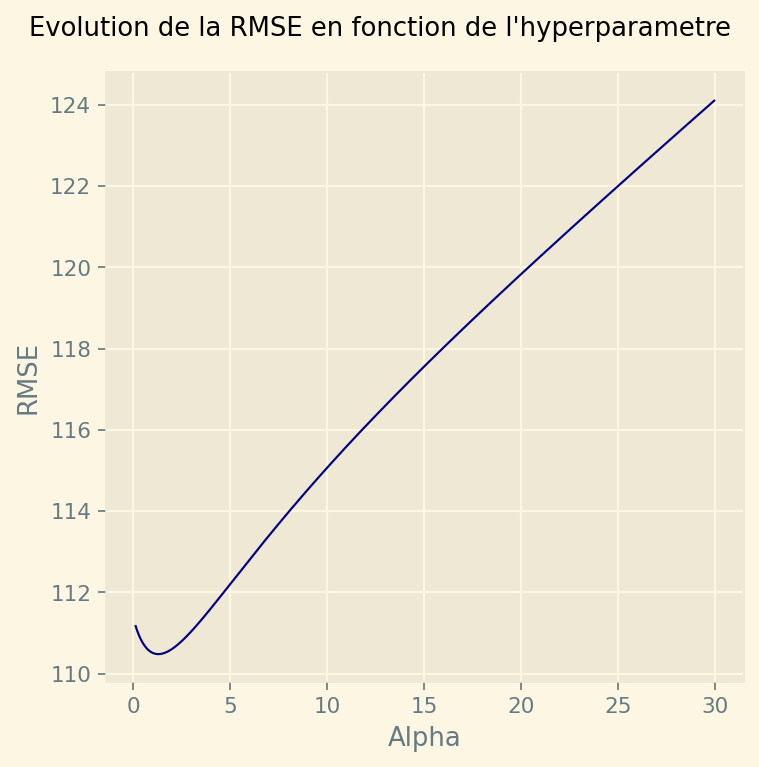

In [38]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")

eui_regression.ridge_plot()


LASSO: 

LASSO best Alpha : 0.9500000000000001
Time used during fit = 0.3485319159226492
Time used during predict = 8.245895151048899e-05


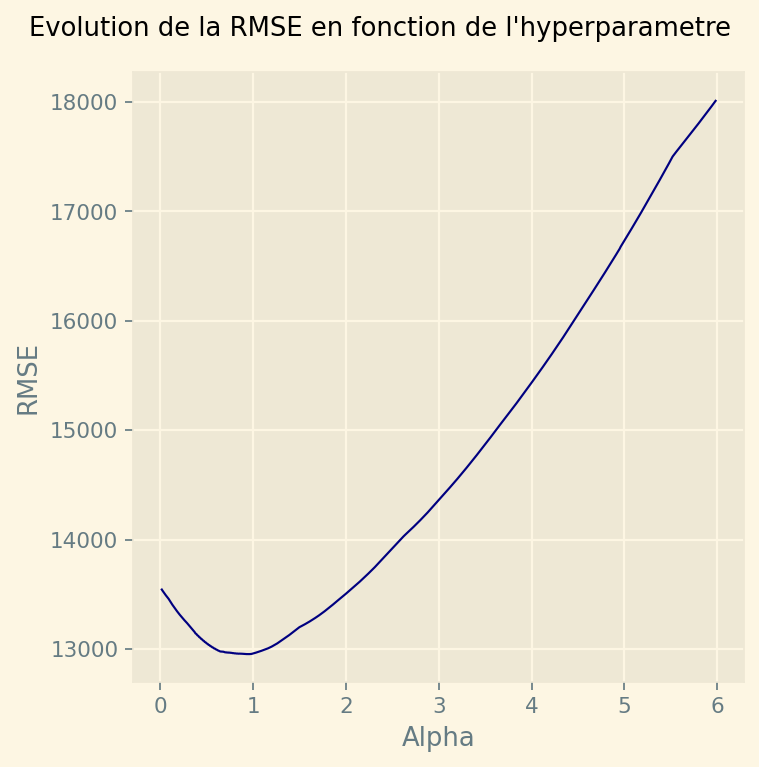

In [39]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")

eui_regression.lasso_plot()


In [40]:
metrics_l1out_no_estar = eui_regression.format_all_metrics()

metrics_l1out_no_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,116.530411,0.663871,110.482589,0.75338,113.814848,0.744595,215.538689,0.745782
Test,116.388233,0.666498,118.466156,0.654484,115.335066,0.672506,120.969609,0.639726
Test/Train,0.999,1.004,1.072,0.869,1.013,0.903,0.561,0.858


In [41]:
metrics_l1out_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,103.091671,0.738351,98.326356,0.806016,100.813213,0.801729,211.88732,0.792946
Test,100.755938,0.750068,102.720646,0.740226,100.005053,0.75378,108.686858,0.709173
Test/Train,0.977,1.016,1.045,0.918,0.992,0.94,0.513,0.894


##### Observations :
- On constate une grande perte de performance sur tous les modèles.
- Sans la présence de variable ENERGYSTAR, les modèles semblent faire plus d'erreurs (augmentation de RMSE de plus ou moins 15%) et leur score R2 baisse, en particulier lors de l'application aux données de test
- Dans le cas de la regression LASSO, les performances d'entrainement baissent (R2 baise de plus de 0.06), mais c'est lors de l'application sur les données de test qu'on constate les pertes plus lourdes : le score R2 baisse de .08 environ et la RMSE augmente de 15kW/m2 en comparaison avec les metriques du modèle utilisant E*


#### 2.2.b : Cross validation = RepeatedKfold (10 folds aléatoires, 3 répétitions)

- On utilise exactement les mêmes paramètres que l'étape précédente.
- On effectue 4 régressions (OLS, Ridge, Lasso et Elastic Net) mise à jour des paramètres par défaut de la classe pour la validation croisée : RepeatedKfold(10 splits, 3 exécutions).

In [42]:
eui_regression.common_parameters["cv"] = k_folds


In [43]:
eui_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)


In [44]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.1
Time used during fit = 40.39169995801058
Time used during predict = 5.787494592368603e-05


In [45]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")


Ridge: 

Ridge best Alpha : 1.1400000000000003
Time used during fit = 17.93855004105717
Time used during predict = 5.362497176975012e-05


In [46]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")


LASSO: 

LASSO best Alpha : 1.0
Time used during fit = 2.0901202500099316
Time used during predict = 0.0002692500129342079


In [47]:
metrics_kfold_no_estar = eui_regression.format_all_metrics()

metrics_kfold_no_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,111.525722,0.694601,0.836113,0.754132,110.272552,0.743695,222.055113,0.745782
Test,116.388233,0.666498,118.149676,0.656327,115.43197,0.671956,120.969609,0.639726
Test/Train,1.044,0.96,141.308,0.87,1.047,0.904,0.545,0.858


In [48]:
metrics_kfold_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,99.464371,0.755986,0.871025,0.806401,98.094811,0.802168,218.234635,0.792946
Test,100.755938,0.750068,102.466601,0.741509,100.008468,0.753763,108.686858,0.709173
Test/Train,1.013,0.992,117.639,0.92,1.02,0.94,0.498,0.894


##### Observations sur l'importance d'Energy Star :
- Ici, contrairement a la modelisation de la prediction d'emission de GaES, la variable E* score semble très importante. On note de fortes baisses du score R2 de chaque modèle, et egalement une augmentation de l'erreur RMSE

#### Hypothèses :

- On sait que les batiments notés par EnergyStar sont qualifiés EnergyStar Certified s'ils ont une note superieure ou egale a 75.
- Est il possible de predire avec une haute confiance si un batiment aura une certification ou non ?
- Si oui, cette nouvelle statistique booleene aurait-elle un impact sur notre modele ? Si c'est le cas, il serait avantageux de tenter de predire ce score en utilisant des methode de classification. Cela permettrait d'avoir moins recours au calcul du score Per Se tout en retenant les benefices clairs apportés par cette variable

### <u>2.3 : Utilisation de la certification, sans le score</u>

In [49]:
eui_regression.reset_cols()
eui_regression.drop_col(["ENERGYSTARScore"])
eui_regression.common_parameters["cv"] = None  # Reset cv to L1out


On garde exactement les mêmes paramètres.

In [50]:
# Let's fire up this bad boy : 
# Do me proud homes

eui_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)


In [51]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.1
Time used during fit = 6.506621624925174
Time used during predict = 9.75410221144557e-05


In [52]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")


Ridge: 

Ridge best Alpha : 1.2600000000000002
Time used during fit = 0.1070897919125855
Time used during predict = 6.358395330607891e-05


In [53]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")


LASSO: 

LASSO best Alpha : 0.87
Time used during fit = 0.301795499981381
Time used during predict = 0.00011262495536357164


In [54]:
cert_metrics_l1out = eui_regression.format_all_metrics()

cert_metrics_l1out


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,111.136087,0.694001,105.053882,0.779177,108.203084,0.77177,215.287371,0.771302
Test,107.044804,0.717895,109.631724,0.704095,106.445299,0.721046,112.671364,0.687459
Test/Train,0.963,1.034,1.044,0.904,0.984,0.934,0.523,0.891


In [55]:
metrics_l1out_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,103.091671,0.738351,98.326356,0.806016,100.813213,0.801729,211.88732,0.792946
Test,100.755938,0.750068,102.720646,0.740226,100.005053,0.75378,108.686858,0.709173
Test/Train,0.977,1.016,1.045,0.918,0.992,0.94,0.513,0.894


In [56]:
metrics_l1out_no_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,116.530411,0.663871,110.482589,0.75338,113.814848,0.744595,215.538689,0.745782
Test,116.388233,0.666498,118.466156,0.654484,115.335066,0.672506,120.969609,0.639726
Test/Train,0.999,1.004,1.072,0.869,1.013,0.903,0.561,0.858


In [57]:
# Saving LassoCV_Cert_l1out

lasso_cv_l1out_cert = eui_regression.lasso_cv


In [58]:
eui_regression.common_parameters["cv"] = k_folds

eui_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)


In [59]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.1
Time used during fit = 40.80972274998203
Time used during predict = 0.00010316597763448954


In [60]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")


Ridge: 

Ridge best Alpha : 0.9800000000000001
Time used during fit = 19.92212062503677
Time used during predict = 0.0003410830395296216


In [61]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")


LASSO: 

LASSO best Alpha : 0.92
Time used during fit = 1.970118833007291
Time used during predict = 0.00014816701877862215


In [62]:
cert_metrics_kfolds = eui_regression.format_all_metrics()

cert_metrics_kfolds


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,105.863892,0.723692,0.852912,0.780444,104.545762,0.770964,221.960857,0.771302
Test,107.044804,0.717895,108.981196,0.707596,106.578629,0.720347,112.671364,0.687459
Test/Train,1.011,0.992,127.775,0.907,1.019,0.934,0.508,0.891


In [63]:
cert_metrics_l1out


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,111.136087,0.694001,105.053882,0.779177,108.203084,0.77177,215.287371,0.771302
Test,107.044804,0.717895,109.631724,0.704095,106.445299,0.721046,112.671364,0.687459
Test/Train,0.963,1.034,1.044,0.904,0.984,0.934,0.523,0.891


In [64]:
metrics_kfold_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,99.464371,0.755986,0.871025,0.806401,98.094811,0.802168,218.234635,0.792946
Test,100.755938,0.750068,102.466601,0.741509,100.008468,0.753763,108.686858,0.709173
Test/Train,1.013,0.992,117.639,0.92,1.02,0.94,0.498,0.894


In [65]:
metrics_kfold_no_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,111.525722,0.694601,0.836113,0.754132,110.272552,0.743695,222.055113,0.745782
Test,116.388233,0.666498,118.149676,0.656327,115.43197,0.671956,120.969609,0.639726
Test/Train,1.044,0.96,141.308,0.87,1.047,0.904,0.545,0.858


#### Observations :
- Les résultats sont encourageants. Il est évident que la certification, ou non, d'un bâtiment n'est pas aussi précise que son score mais on obtient un gain significatif par rapport aux modèles n'utilisant pas du tout le score EnergyStar.
- Si l'on garde l'exemple de LASSO, on obtient des résultats sensiblement plus optimistes. On perd certes en précision et on augmente l'erreur vis à vis du modèle utilisant E* seul, mais cela peut être un compromis intéressant.
- Ici également, la difference la methode de validation croisee par Leave One Out semble plus performante que Repeated KFolds
- On peut étudier l'importance de la feature avec la même méthode (SHAP) utilisée lors des précédents exemples. On s'attend a la voir contribuer substantiellement au modèle.

In [66]:
target_and_score = [eui_target, "ENERGYSTARScore"]

X_all_cert = eui_regression.df_origin.drop(columns=target_and_score).to_numpy()
X100 = shap.utils.sample(X_all_cert, 100) # 100 instances for use as the background distribution

features_cert = eui_regression.df_origin.drop(columns=target_and_score).columns

explainer = shap.LinearExplainer(lasso_cv_l1out_cert, X100, feature_names=features_cert)
shap_values = explainer(X_all_cert)


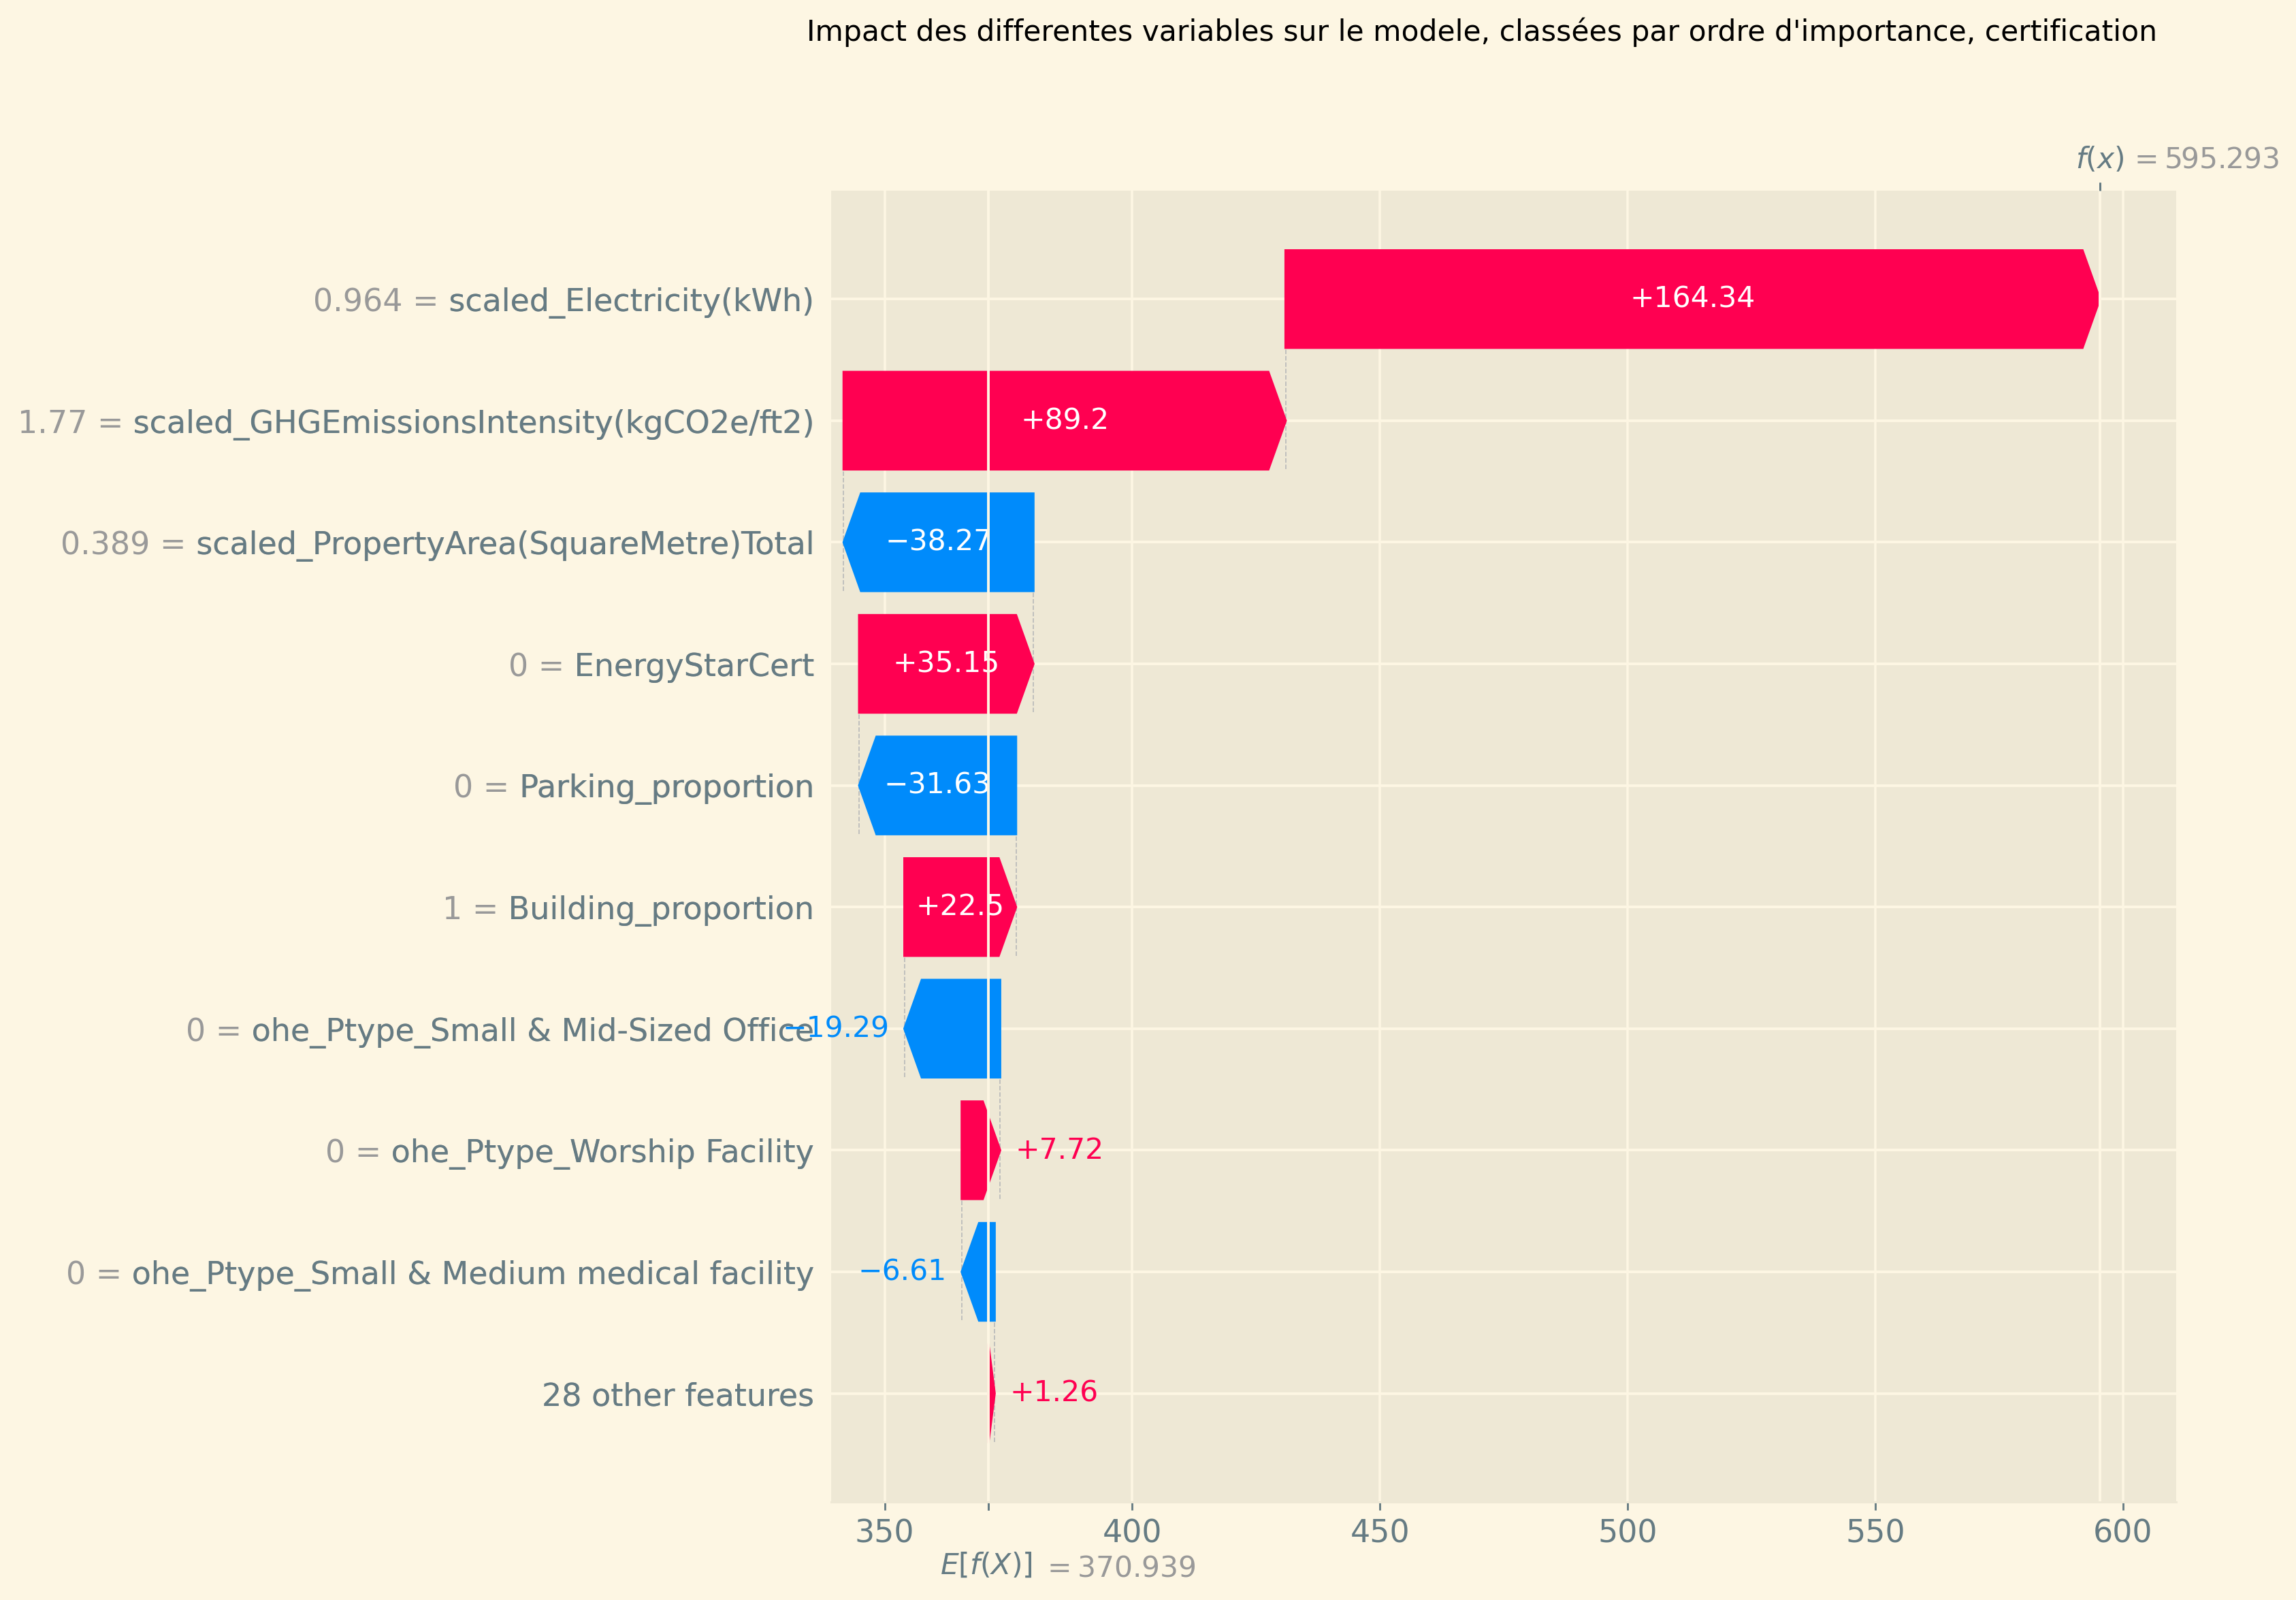

In [67]:
sample_ind = 18
my_waterfall = shap.plots.waterfall(shap_values[0], max_display=10, show=False)
my_waterfall.figure.set_size_inches(10, 10)
my_waterfall.figure.set_dpi(pc_dpi)

my_waterfall.suptitle("Impact des differentes variables sur le modele, classées par ordre d'importance, certification")

plt.show()


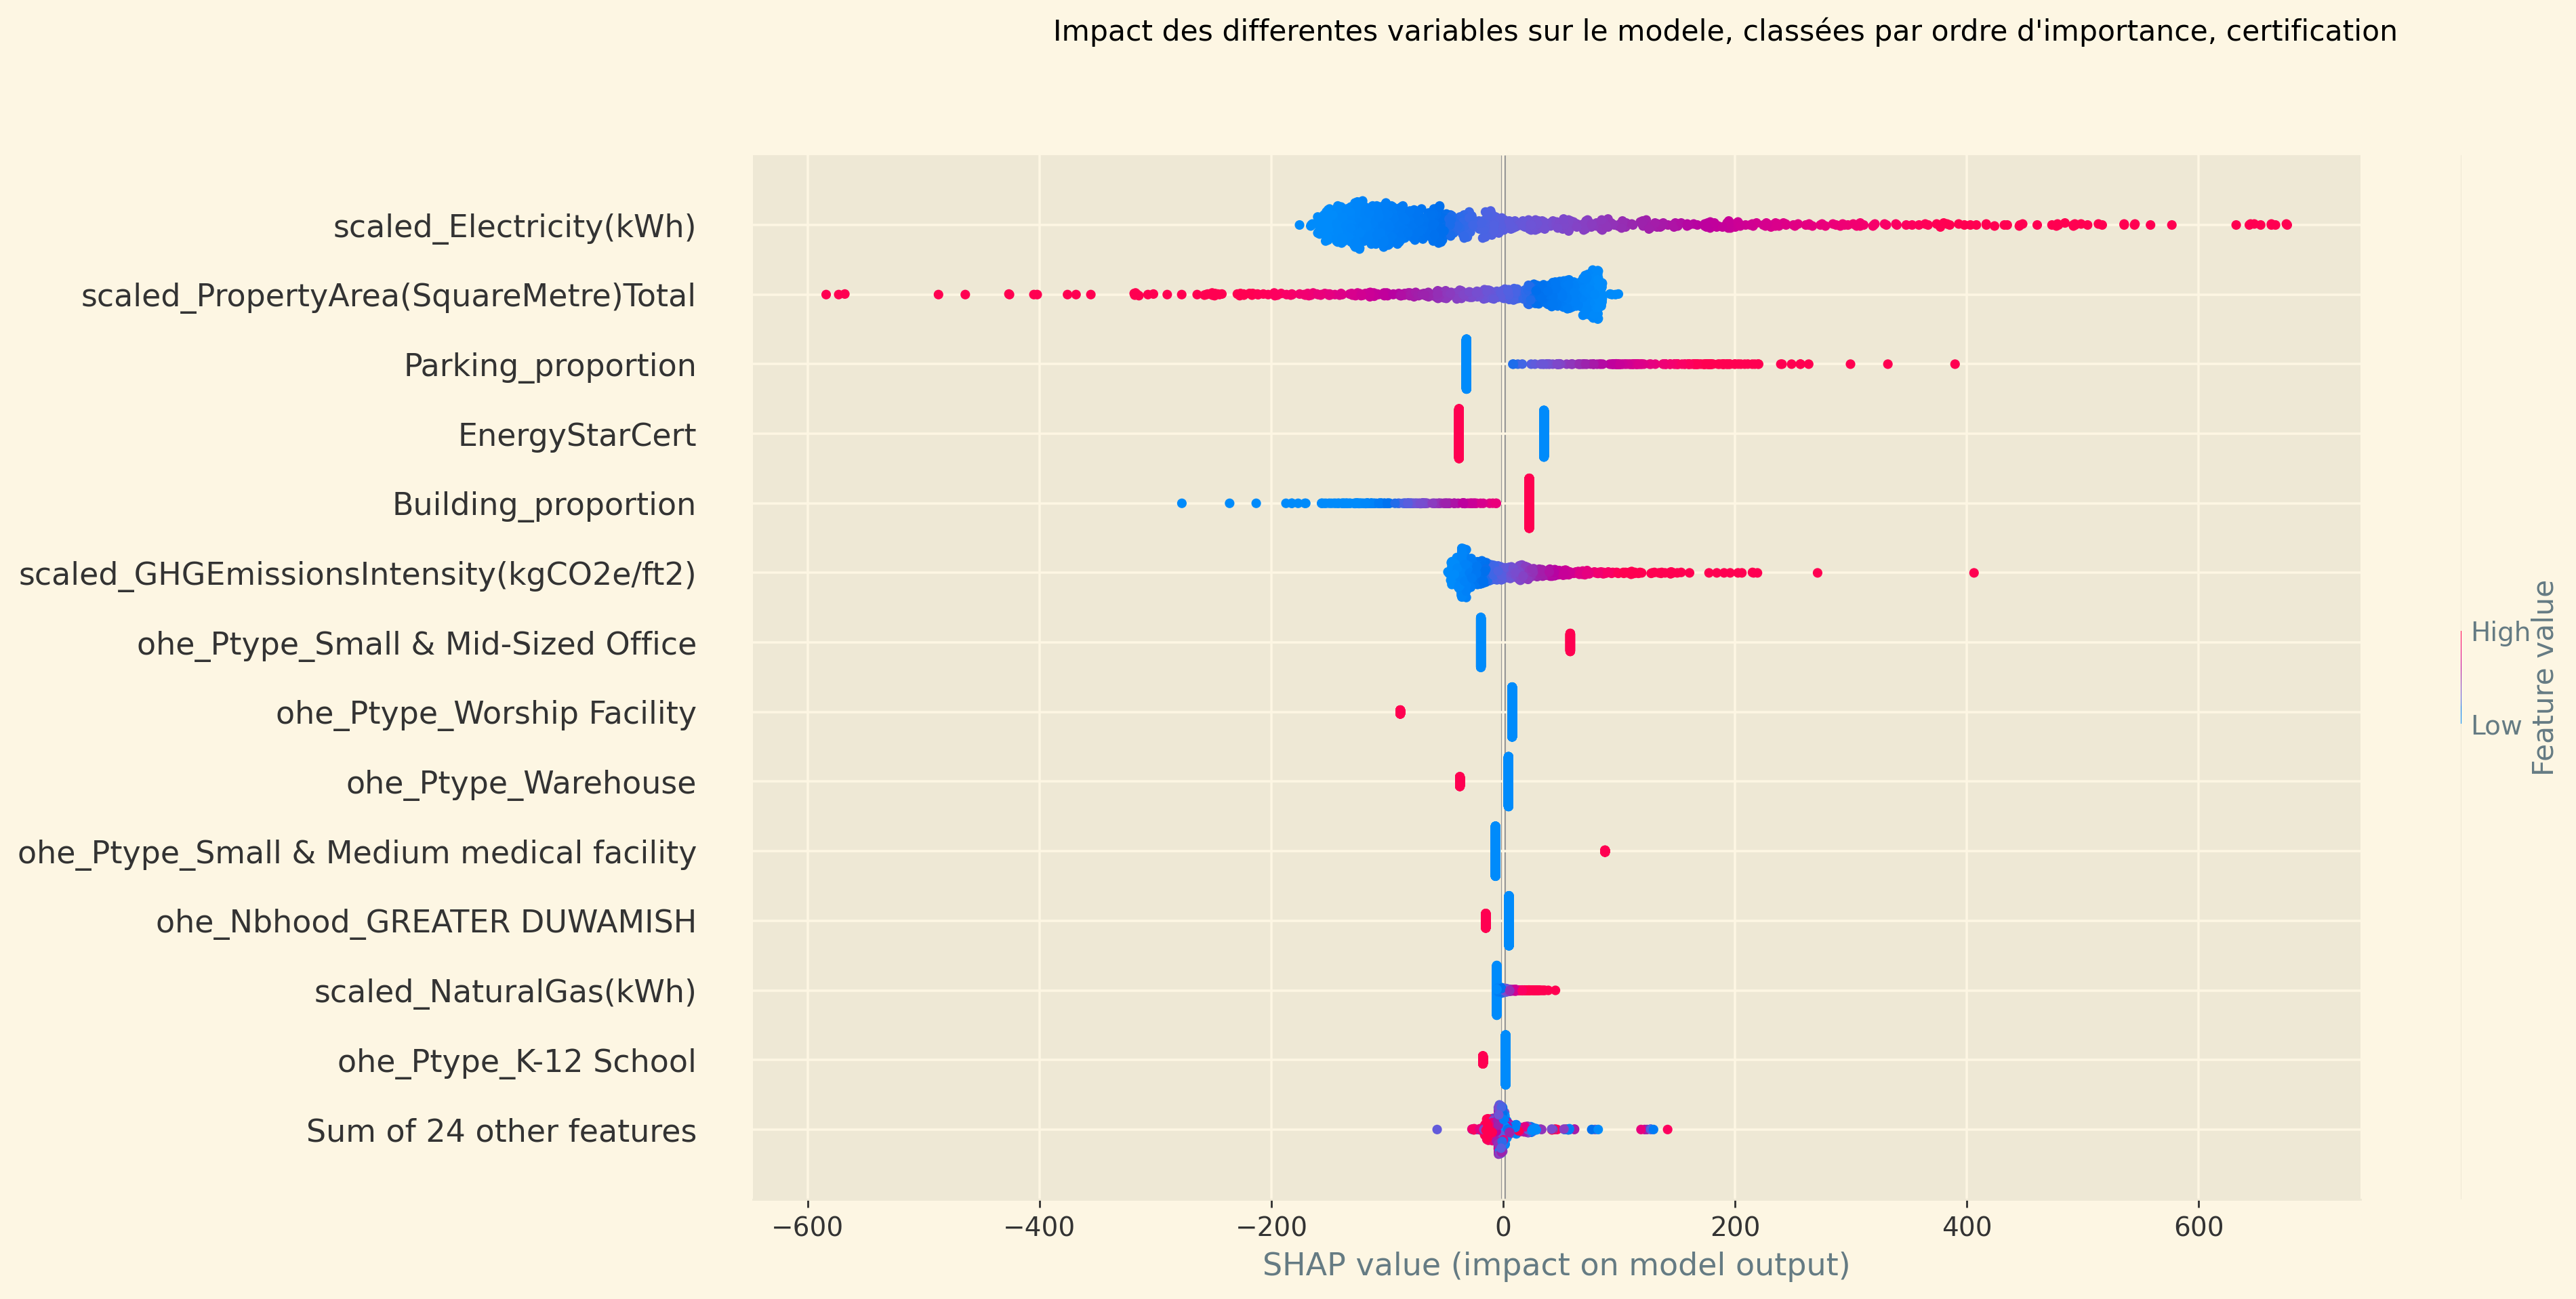

In [68]:
summary = shap.plots.beeswarm(shap_values, max_display=14, show=False)

summary.figure.set_size_inches(15, 8)
summary.figure.set_dpi(pc_dpi)

summary.suptitle("Impact des differentes variables sur le modele, classées par ordre d'importance, certification")

plt.show()


### Observations sur l'hypothese et ouverture vers un autre probleme. Conclusion générale.

- L'hypothèse selon laquelle la certification, ou non, d'un batiment apporte une contribution sembable en terme d'impact à celle de la Note Per Se.
- Les resultats sont particulierement interessants dans la mesure ou l'on passe d'une note sur 100 à une valeur binaire.
- Cependant, un autre probleme se pose : Nous avons pu etablir la certification des batiments en connaissant a priori leurs notes. L'idée est d'essayer de moins s'appuyer sur cette note - En clair, une nouvelle problematique emerge : Est il possible de predire si un batiment sera certifié ou non, en se basant sur les variables connues.
    - Dans le cas ou cela est possible est suffisamment precis, cette alternative est un bon compromis entre les pertes de performances consequentes dues à l'elimination totale d'E*.
    - Dans le cas ou cela est impossible ou trop peu precis. On recommandera, au possible, d'effectuer les calculs de ce score. La difference "avec/sans" est trop importante et le modele beneficie trop du score pour s'en passer.
- Dans l'ensemble, l'utilisation de la regression LASSO est conseillée avec une pénalisation `alpha = 0.87` : c'est le modèle le plus precis (R2 le plus élevé et RMSE plus faible)